In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchmetrics as tm

# Device configuration
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
# print(f"CUDA version: {torch.version.cuda}")
 
# # Storing ID of current CUDA device
# cuda_id = torch.cuda.current_device()
# print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
# print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

In [21]:
bs = 1000

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])
    
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
if torch.cuda.is_available():
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=6)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False, num_workers=6)
else: 
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False, num_workers=0)

In [24]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super().__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [25]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

#Set evaluation metrics

D_realacc = tm.classification.BinaryAccuracy().to(device)
D_fakeacc = tm.classification.BinaryAccuracy().to(device)
D_accuracy = tm.classification.BinaryAccuracy().to(device)
G_accuracy = tm.classification.BinaryAccuracy().to(device)

In [26]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [27]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [28]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [29]:
def D_train(x):
    #=======================Train the discriminator=======================#

    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_pred = D_output
    D_real_target = torch.ones_like(D_real_pred)

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_pred = D_output
    D_fake_target = torch.zeros_like(D_fake_pred)

    # evaluation metrics
    D_realacc.update(D_real_pred, D_real_target)
    D_fakeacc.update(D_fake_pred, D_fake_target)
    D_accuracy.update(torch.cat((D_real_pred, D_fake_pred), -1), torch.cat((D_real_target, D_fake_target), -1))
    G_accuracy.update(D_fake_pred, D_real_target)
    # gradient backprop & optimize ONLY D's parameters
    D_loss = (D_real_loss + D_fake_loss) / 2 # average of real loss and fake loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [30]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    # Generator loss is the BCE loss of the discriminator output (whether image is real or generated) against labels (set to all real images)
    # This value is 0 when the discriminator thinks all generated images are real. So this value should trend to 0. 
    G_loss = criterion(D_output, y)  

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    D.to(device)
    D = nn.DataParallel(D)
    print("D moved to GPU and using data parallelism")
else:
    print("GPU is not available, using CPU instead")   

if torch.cuda.is_available():
    device = torch.device("cuda")
    G.to(device)
    G = nn.DataParallel(G)
    print("G moved to GPU and using data parallelism")
else:
    print("GPU is not available, using CPU instead")    

GPU is not available, using CPU instead
GPU is not available, using CPU instead


[1/300]: loss_d: 0.495, loss_g: 1.106
[2/300]: loss_d: 0.382, loss_g: 1.525
[3/300]: loss_d: 0.691, loss_g: 1.618
[4/300]: loss_d: 0.648, loss_g: 3.050
[5/300]: loss_d: 0.207, loss_g: 4.277
[6/300]: loss_d: 0.505, loss_g: 1.783
[7/300]: loss_d: 0.733, loss_g: 1.000
[8/300]: loss_d: 0.531, loss_g: 1.205
[9/300]: loss_d: 0.447, loss_g: 2.707
[10/300]: loss_d: 0.501, loss_g: 1.504
[11/300]: loss_d: 0.541, loss_g: 2.596
[12/300]: loss_d: 0.748, loss_g: 2.629
[13/300]: loss_d: 0.560, loss_g: 2.142
[14/300]: loss_d: 0.723, loss_g: 1.804
[15/300]: loss_d: 0.715, loss_g: 0.932
[16/300]: loss_d: 0.425, loss_g: 1.563
[17/300]: loss_d: 0.753, loss_g: 1.997
[18/300]: loss_d: 0.623, loss_g: 1.174
[19/300]: loss_d: 0.414, loss_g: 2.834
[20/300]: loss_d: 0.728, loss_g: 1.508
[21/300]: loss_d: 0.712, loss_g: 1.826
[22/300]: loss_d: 0.567, loss_g: 1.808
[23/300]: loss_d: 0.462, loss_g: 1.063
[24/300]: loss_d: 0.695, loss_g: 0.910
[25/300]: loss_d: 0.487, loss_g: 1.187
[26/300]: loss_d: 0.501, loss_g: 1

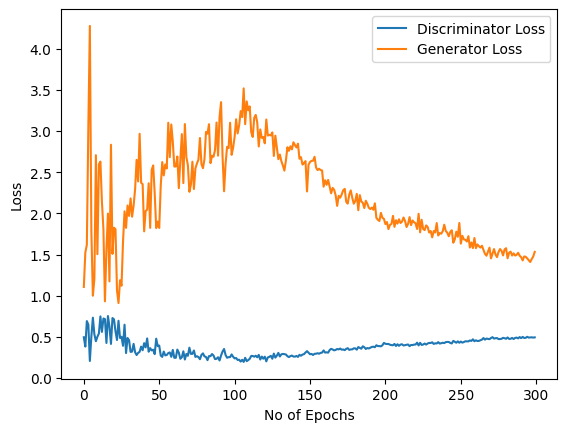

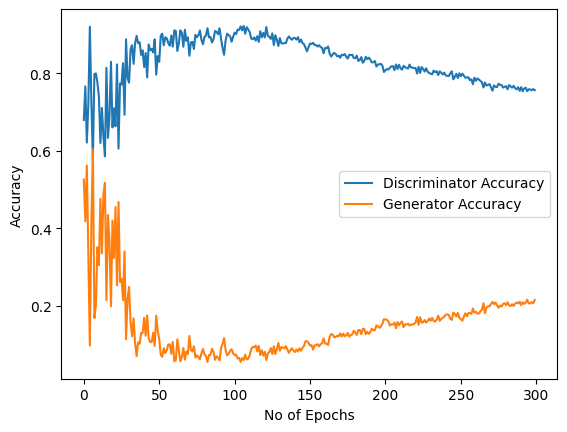

In [32]:
n_epoch = 300
D_losses, G_losses = [], []
D_r_acc, D_f_acc = [], []
D_acc, G_acc = [], []
test_z = Variable(torch.randn(100, z_dim).to(device))

for epoch in range(1, n_epoch+1):           
    
    D_batch_losses, G_batch_losses = [], []



    for batch_idx, (x, _) in enumerate(train_loader):
        D_batch_losses.append(D_train(x))
        G_batch_losses.append(G_train(x))


    D_r_acc.append(D_realacc.compute())
    D_f_acc.append(D_fakeacc.compute())
    D_acc.append(D_accuracy.compute())
    G_acc.append(G_accuracy.compute())

    D_epochloss = torch.mean(torch.FloatTensor(D_batch_losses))
    G_epochloss = torch.mean(torch.FloatTensor(G_batch_losses))
    D_losses.append(D_epochloss)
    G_losses.append(G_epochloss)

    D_realacc.reset()
    D_fakeacc.reset()
    D_accuracy.reset()
    G_accuracy.reset()
        

    if epoch % 10 == 0:
        with torch.no_grad():
            generated = G(test_z)
            save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_{}'.format(epoch) + '.png')


    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, D_epochloss, G_epochloss))

plt.figure()
plt.plot(D_losses, label="Discriminator Loss")
plt.plot(G_losses, label="Generator Loss")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.savefig('./samples/Loss_plot.png')

plt.figure()
plt.plot(D_acc, label="Discriminator Accuracy")
plt.plot(G_acc, label="Generator Accuracy")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.savefig('./samples/Acc_plot.png')


In [14]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + '.png')

Text(0, 0.5, 'Loss')

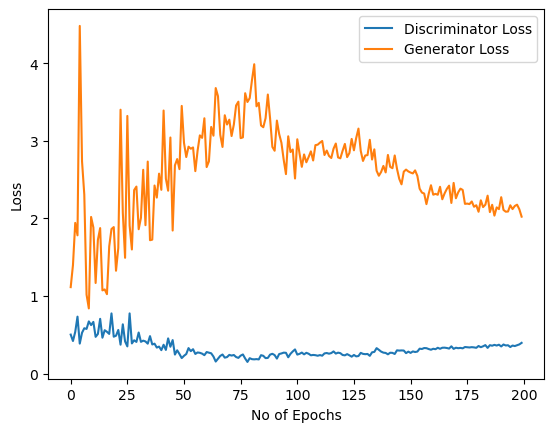

In [ ]:
plt.plot(D_losses, label="Discriminator Loss")
plt.plot(G_losses, label="Generator Loss")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Loss")

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

#Set evaluation metrics

D_realacc = tm.classification.BinaryAccuracy().to(device)
D_fakeacc = tm.classification.BinaryAccuracy().to(device)
D_accuracy = tm.classification.BinaryAccuracy().to(device)
G_accuracy = tm.classification.BinaryAccuracy().to(device)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
beta1 = 0.6
beta2 = 0.9
G_optimizer = optim.Adam(G.parameters(), lr = lr, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr = lr, betas=(beta1, beta2))

In [ ]:
n_epoch = 300
D_losses, G_losses = [], []
D_r_acc, D_f_acc = [], []
D_acc, G_acc = [], []

for epoch in range(1, n_epoch+1):           
    
    D_batch_losses, G_batch_losses = [], []



    for batch_idx, (x, _) in enumerate(train_loader):
        D_batch_losses.append(D_train(x))
        G_batch_losses.append(G_train(x))


    D_r_acc.append(D_realacc.compute())
    D_f_acc.append(D_fakeacc.compute())
    # D_acc.append(D_accuracy.compute())
    G_acc.append(G_accuracy.compute())

    D_epochloss = torch.mean(torch.FloatTensor(D_batch_losses))
    G_epochloss = torch.mean(torch.FloatTensor(G_batch_losses))
    D_losses.append(D_epochloss)
    G_losses.append(G_epochloss)

    D_realacc.reset()
    D_fakeacc.reset()
    # D_accuracy.reset()
    G_accuracy.reset()
        

    if epoch % 10 == 0:
        with torch.no_grad():
            test_z = Variable(torch.randn(100, z_dim).to(device))
            generated = G(test_z)
            save_image(generated.view(generated.size(0), 1, 28, 28), './samples/trial 5/sample_{}'.format(epoch) + '.png')


    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, D_epochloss, G_epochloss))